In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import odom_utils as odou
from visualization import papermode

# papermode(plt, size=18)


In [2]:
# Parameters
abbr = "R08"


In [3]:
preprocess(abbr, verbose=False)
m2009df = morales2009.morales2009(abbr, verbose=False)
p2014df = pentzer2014pow.pentzer2014pow(abbr, verbose=False)
p2022df = pentzer2022.pentzer2022(abbr, verbose=False)


R08: 100%|██████████| 1553/1553 [00:00<00:00, 3311.52it/s]


In [4]:
basename = u.get_basename(u.get_filename(abbr))
figdir = u.get_figdir(basename, subdir=f"maps")
rundir = u.get_rundir(basename)
gps_df = pd.read_csv(rundir/f"{abbr}-DEMelevation.csv")

In [5]:
if not "long" in p2022df.columns.values:
    coords = odou.transform_odom(
        p2022df.px,
        p2022df.py,
        abbr=abbr
    )
else:
    coords = p2022df[["long", "lat"]].copy().rename(columns={"long":"lon"})

In [6]:
all_dfs = (m2009df, p2014df, p2022df)
for df in all_dfs:
    df.rename(columns={"long":"lon"},inplace=True)

# $\mu$ vs elevation

Text(0.5, 0, '$\\mu$')

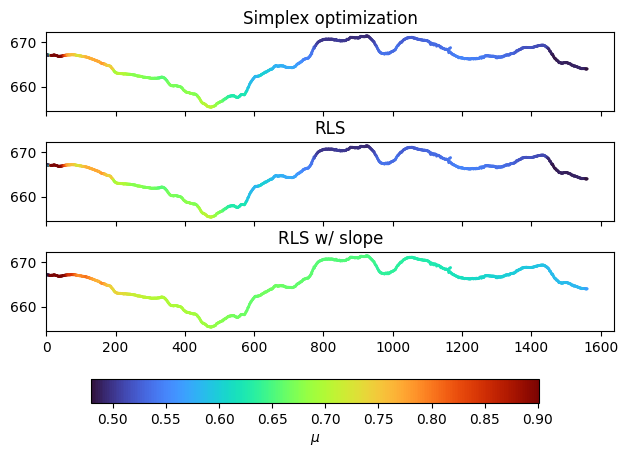

In [17]:
fig, subfigs = plt.subplots(nrows=3, sharex=True)

cseries = pd.concat([df.m_sym.iloc[50:] for df in all_dfs], ignore_index=True)
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

[ax1, ax2, ax3] = subfigs

sc1 = ax1.scatter(m2009df.time_rel, gps_df.Z, c=scmap.to_rgba(m2009df.m_sym), s=1)
sc2 = ax2.scatter(p2014df.time_rel, gps_df.Z, c=scmap.to_rgba(p2014df.m_sym), s=1)
sc3 = ax3.scatter(p2022df.time_rel, gps_df.Z, c=scmap.to_rgba(p2022df.m_sym), s=1)

ax1.set_title("Simplex optimization")
ax2.set_title("RLS")
ax3.set_title("RLS w/ slope")

ax1.set_xlim(left=0)

fig.tight_layout()

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(scmap, orientation="horizontal", cax=cbar_ax)
cbar_ax.set_xlabel("$\mu$")
# cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)


# for ext in u.EXTS:
#     fig.savefig(figdir / f"{abbr}_msym_map.{ext}", bbox_inches="tight")


# Cartopy

In [ ]:
import cartopy.io.img_tiles as cimgt
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


In [ ]:
tiler = cimgt.GoogleTiles(
    url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

fig, subfigs = plt.subplots(ncols=3, sharey=True, subplot_kw={"projection": tiler.crs}, figsize=(7, 5))

for idx, ax in enumerate(subfigs.reshape(-1)):
    gl = ax.gridlines(
        draw_labels=True,
        color="k",
        alpha=0.4,
        linestyle="--",
        dms=True,
        x_inline=False,
        y_inline=False,
    )
    gl.top_labels = gl.right_labels = False
    gl.left_labels = True if idx == 0 else False
    ax.xaxis.set_major_formatter(LatitudeFormatter(dms=True))
    ax.yaxis.set_major_formatter(LongitudeFormatter(dms=True))

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

for ax in subfigs.reshape(-1):
    ax.set_extent(extent)
    # ax.stock_img()
    ax.add_image(tiler, 15)

cseries = pd.concat([df.m_sym.iloc[50:] for df in all_dfs], ignore_index=True)
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

[ax1, ax2, ax3] = subfigs

sc1 = ax1.scatter(m2009df.lon, m2009df.lat, c=scmap.to_rgba(m2009df.m_sym), s=1, transform=ccrs.PlateCarree())
sc2 = ax2.scatter(p2014df.lon, p2014df.lat, c=scmap.to_rgba(p2014df.m_sym), s=1, transform=ccrs.PlateCarree())
sc3 = ax3.scatter(p2022df.lon, p2022df.lat, c=scmap.to_rgba(p2022df.m_sym), s=1, transform=ccrs.PlateCarree())

ax1.set_title("Simplex\noptimization")
ax2.set_title("RLS")
ax3.set_title("RLS w/ slope")

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(scmap, orientation="horizontal", cax=cbar_ax)
cbar_ax.set_xlabel("$\mu$")
# cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_msym_map.{ext}", bbox_inches="tight")


In [ ]:
tiler = cimgt.GoogleTiles(
    url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})
gl = ax.gridlines(draw_labels=True, color="k", alpha=0.6)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
# ax.stock_img()
ax.add_image(tiler, 15)

cseries = p2022df.EWMAt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(coords.lon, coords.lat, c=scmap.to_rgba(cseries), s=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)
cb.ax.set_xlabel("EWMA of Power Estimate Error $EWMA(P_e)$")
for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_ewma_map.{ext}", bbox_inches="tight")


In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})
gl = ax.gridlines(draw_labels=True, color="k", alpha=0.6)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# extent = [-45, -38.25, 13.25, -15]
extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
# ax.stock_img()
ax.add_image(tiler, 15)

cseries = p2022df.Perrt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(coords.lon, coords.lat, c=scmap.to_rgba(cseries), s=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)
cb.ax.set_xlabel("Power estimate error $P_e=P_m - P$")
for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_perrsym_map.{ext}", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = p2022df.Perrt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(p2022df.time_rel, p2022df.theta, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("Power Estimation Error $P_{err}$")

ax.set_xlabel("Elapsed time (s)")
ax.set_ylabel("Pitch (rad)")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_perrsym_pitcht.{ext}", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = p2022df.Perrt_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(p2022df.theta, p2022df.m_sym, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("Power Estimation Error $P_{err}$")

ax.set_xlabel("Pitch (rad)")
ax.set_ylabel("$\\mu$")
ax.set_ylim(bottom=0.5, top=1)

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_slope_beta_perr.{ext}", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

cseries = p2022df.B_sym.copy()

cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[100:800].min(),
    vmax=cseries.iloc[100:800].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)
ax.scatter(p2022df.time_rel, p2022df.theta, c=scmap.to_rgba(cseries), s=2)
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.12, ax=ax)
cb.ax.set_xlabel("$\\beta$")

ax.set_xlabel("Elapsed time (s)")
ax.set_ylabel("Pitch (rad)")

fig.tight_layout()

for ext in u.EXTS:
    fig.savefig(figdir / f"{abbr}_bsym_slope.{ext}", bbox_inches="tight")

# DONE

In [ ]:
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(vmin=min(p2022df.time_rel), vmax=max(p2022df.time_rel))
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(p2022df.m_sym, p2022df.G_sym, c=scmap.to_rgba(p2022df.time_rel))

ax.set_xlabel("${\mu}_{sym}$")
ax.set_ylabel("${G}_{sym}$")
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.2, ax=ax);
cb.ax.set_xlabel("Time [s]");

fig.suptitle(f"{abbr} - Values of $\mu$, $G$ for symmetric SSMR Gora model");

In [ ]:
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(vmin=min(p2022df.time_rel), vmax=max(p2022df.time_rel))
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(p2022df.m_asym, p2022df.G_asym, c=scmap.to_rgba(p2022df.time_rel))
ax.set_xlabel("${\mu}_{asym}$")
ax.set_ylabel("${G}_{asym}$")
cb = fig.colorbar(scmap, orientation="horizontal", pad=0.2, ax=ax);
cb.ax.set_xlabel("Time [s]");

fig.suptitle(f"{abbr} - Values of $\mu$, $G$ for asymmetric Pentzer2022 model");